# Import Packages

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from models.linear_regression import train_with_CV, train_with_split
from sklearn.base import clone

# Define Constants

In [71]:
# CONSTANTS
MAX_LASERS = 197

# Load Data

In [3]:
df = pd.read_parquet("./data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X = data[:, :-1]
Y = data[:, -1]

print(np.shape(X), np.shape(Y))

(160000, 197) (160000,)


## Load pre-saved Normalized Data

In [4]:
train_normalized = np.load("./data/train_data_normalized.npy")
test_normalized = np.load("./data/test_data_normalized.npy")

X_train_norm  = train_normalized[:, :-1]
Y_train_norm = train_normalized[:, -1]
X_test_norm = test_normalized[:, :-1]
Y_test_norm = test_normalized[:, -1]

Z_raw = pd.read_parquet("./data/test_regression.parquet")
X_test_raw = Z_raw.iloc[:,:-1]
Y_test_raw = Z_raw.iloc[:, -1]
X_test_raw = np.array(X_test_raw, dtype=np.float64)
Y_test_raw = np.array(Y_test_raw, dtype=np.float64)


# Helper Functions

In [76]:
# Normalize Data
def normalize(X_train, X_test, Y_train):
  X_mean = np.mean(X_train, axis=0)
  X_std = np.std(X_train, axis=0)

  X_train_norm = np.array(X_train)
  X_test_norm = np.array(X_test)
  for i in range(len(X_mean)):
    X_train_norm[:, i] = (X_train[:, i] - X_mean[i]) / X_std[i]
    X_test_norm[:, i] = (X_test[:, i] - X_mean[i]) / X_std[i]

  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  Y_train_norm = (Y_train - Y_mean) / Y_std

  return X_train_norm, X_test_norm, Y_train_norm

# Normalize a single data set
def normalize_one(X):
  X_mean = np.mean(X, axis=0)
  X_std = np.std(X, axis=0)

  X_norm = np.array(X)
  for i in range(len(X_mean)):
    X_norm[:, i] = (X[:, i] - X_mean[i]) / X_std[i]

  return X_norm

# Denormalize Y_test based on Y_train
def denormalize(Y_train, Y_test):
  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  return Y_test * Y_std + Y_mean

def showWeightPlot(model, abs=False):
    coef = model.coef_
    if abs:
      coefs = np.abs(model.coef_)
    plt.bar([x for x in range(len(coef))], coef)
    plt.show()

def trainSubset(X, Y, removed, model, metric, **kwargs):
    remaining = [i for i in range(MAX_LASERS) if i not in removed]
    return train_with_CV(X[:, remaining], Y, model, metric, **kwargs)

def calcMSE(model, X, Y_true, Y_train):
    Y_pred = model.predict(X)
    y_pred = Y_pred * Y_train.mean(axis=0) + Y_train.std(axis=0)
    return mean_squared_error(Y_true, Y_pred)

# Beam Searching

### Baseline Testing
Simple linear regression

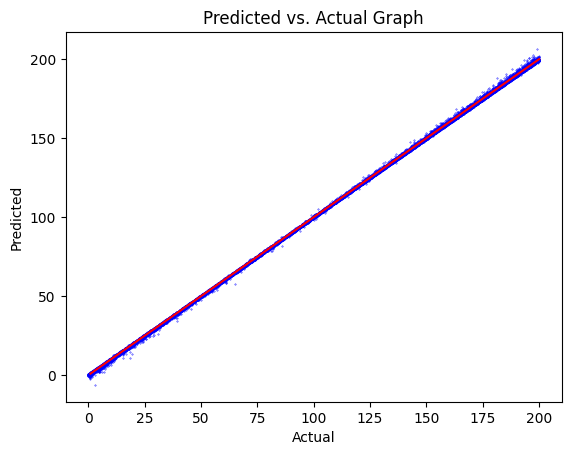

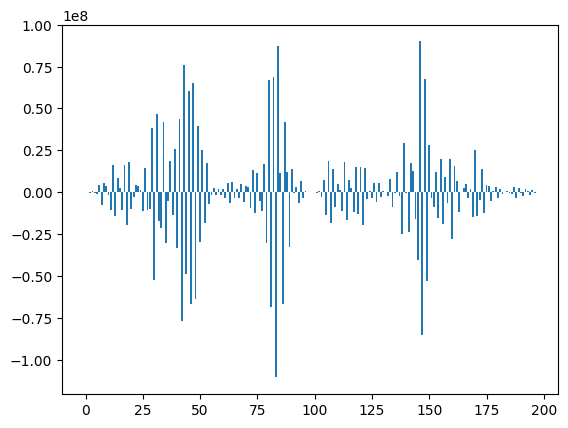

MSE:  0.24856790796160758


In [73]:
base_mse, base_model = train_with_CV(X_train_norm, Y_train_norm, LinearRegression, mean_squared_error)
showWeightPlot(base_model)
print("MSE: ", base_mse)


### Logic for Beam Searching
Warning: This will take a very long time. ~24 hours on a MacBookPro M1 Pro

In [58]:
def trainSubset(X, Y, removed, model, metric, **kwargs):
    remaining = [i for i in range(MAX_LASERS) if i not in removed]
    return train_with_CV(X[:, remaining], Y, model, metric, **kwargs)

In [ ]:
from time import time



lasers = set([i for i in range(MAX_LASERS)])
removed_lasers = []
errors = []
models = []

for i in range(MAX_LASERS):
    start1 = time()
    print("Starting Round:", i+1, "/", MAX_LASERS)
    best_mse = float('inf')
    best_reg = None
    removed_index = -1
    count = 1
    for j in lasers:
        start2 = time()
        print("\tPerforming regression", count, "/", len(lasers))
        count += 1
        curr_mse, curr_reg = trainSubset(X_train_norm, Y_train_norm, removed_lasers +  [j],LinearRegression, mean_squared_error, graph=False)
        if curr_mse < best_mse:
            best_mse, best_reg = curr_mse, curr_reg
            removed_index = j
        end2 = time()
        print("\t\t", end2 - start2, "s")
    end1 = time()
    print("\t", end1 - start1, "s")

    removed_lasers.append(removed_index)
    lasers.remove(removed_index)
    errors.append(best_mse)
    models.append(deepcopy(curr_reg))

# Results

## Removed Lasers

In [10]:
removed_lasers = np.load("removed_lasers.npy")
errors = np.load("errors.npy")

In [11]:
str(removed_lasers)

'[140 164 190   1 135  24  91  85  10 183 137  97 111 168 167 193  27  21\n 131 166 151 185 178 119 116  70  36  15 162   4  55 108 120 107  59 158\n 143 157  78  77  60  58  57   9  38  76  75 159 156 145 153 152 112 110\n 165 169 171 176 109 113 114 115 132 128 117 118 129 124 123 130 121 122\n 179 180 181 194 195 163 161 127 125 126   6   5 106 196 155  11  37 192\n 187 186 182  87  44   0   3   2  67  66  32 184 154 105   8 104  56  41\n  40  69  49  48  47  46  98 103 177 175 174 170 172  22 191 188 189  61\n 102 139 141 133 173 160 150 147 134 100 101  68  43  71  92   7  25  74\n  26  63  90  64  82 138 136 148  83  99  79  73  89  28  65  18  17 142\n  23 149  12  13  14  88  86  84 144 146  19  16  96  93  94  95  72  62\n  20  81  29  30  80  34  35  31  54  53  39  42  50  51  52  33]'

# Saving the Results

In [102]:
import pickle
from joblib import dump, load

In [50]:
np.save('errors.npy', errors)
np.save('removed_lasers.npy', removed_lasers)

In [ ]:
for i in range(1, 198):
    print(i)
    dump(models[i-1], 'linear_reg_models/removed_' + str(i) + '.joblib') 

## Regenerating the models based on the removed lasers because there was an error

In [69]:
models_list = []
errors = []
for i in range(MAX_LASERS):
    res, reg = trainSubset(X_train_norm, Y_train_norm, removed_lasers[:i], LinearRegression, mean_squared_error, graph=False)
    models_list.append(deepcopy(reg))
    errors.append(res)

Save the models

In [68]:
for i in range(0, MAX_LASERS):
    dump(models_list[i], 'linear_reg_models/removed_' + str(i) + '.joblib')
np.save("errors.npy", errors)

Load the Models

In [111]:
models_list = []
for i in range(0, MAX_LASERS):
    loaded_model = load("linear_reg_models/removed_"  + str(i) +".joblib")
    models_list.append(deepcopy(loaded_model))
errors = np.load("errors.npy")

Execute this if necessary
i.e. if len(model_lists) and len(errors) is 196 instead of 197

In [116]:
if len(models_list) != MAX_LASERS:
    models_list = [base_model] + list(models_list)
if len(errors) != MAX_LASERS:
    errors = [base_mse] + list(errors)

# Error Graphs

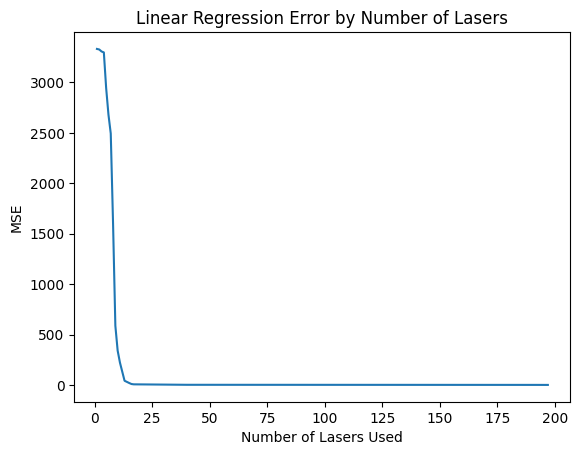

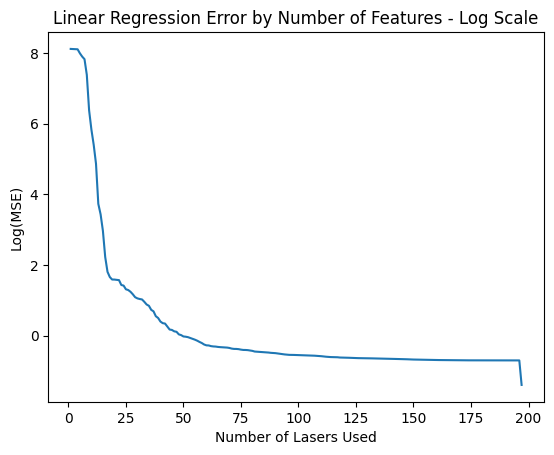

In [117]:
plt.plot(np.arange(197, 0, -1), errors)
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")
plt.title("Linear Regression Error by Number of Lasers")
plt.show()

plt.plot(np.arange(197, 0, -1), np.log(errors))
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")
plt.title("Linear Regression Error by Number of Features - Log Scale")
plt.show()

## Calculate Out of Sample MSE

In [40]:
outSampleMSE = []
for model in models_list:
    n_features = len(model.coef_)
    remaining = [i for i in range(197) if i not in removed_lasers[:197 - n_features]]

    outSampleMSE.append(calcMSE(model, X_test_norm[:, remaining], Y_test_raw, Y))

Text(0, 0.5, 'MSE')

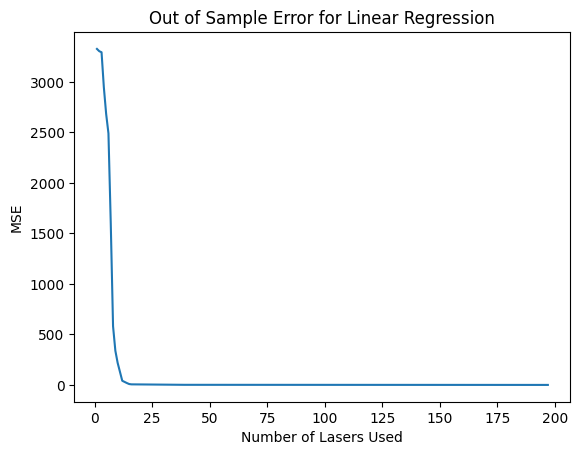

In [41]:
plt.plot(np.arange(197, 0, -1), outSampleMSE)
plt.title("Out of Sample Error for Linear Regression")
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")

Text(0, 0.5, 'Log(MSE)')

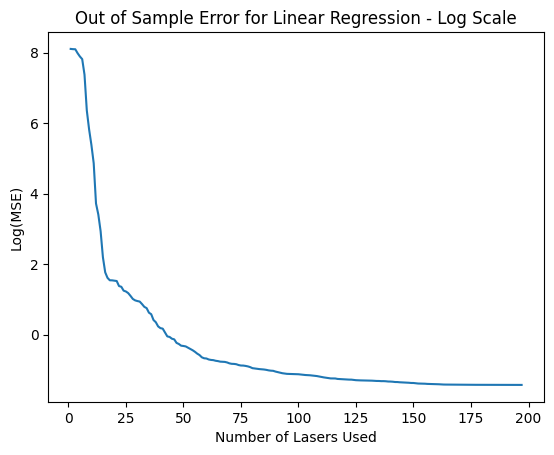

In [42]:
plt.plot(np.arange(197, 0, -1), np.log(outSampleMSE))
plt.title("Out of Sample Error for Linear Regression - Log Scale")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

Text(0, 0.5, 'Log(MSE)')

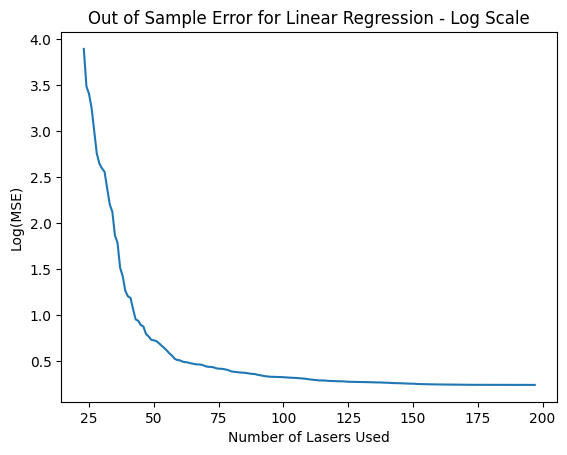

In [43]:
plt.plot(np.arange(MAX_LASERS, 22, -1), outSampleMSE[:175])
plt.title("Out of Sample Error for Linear Regression - Log Scale")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

# Create GIFS

## Imports

In [78]:
import imageio.v2 as imageio
import os

### Generate the intermediary gif frames points

In [44]:
coordinates = []
coordinate_colors = []
initial_colors = ["blue"] * MAX_LASERS

for i in range(MAX_LASERS):
    coefs = models_list[i].coef_
    if i < len(removed_lasers):
        initial_colors = initial_colors.copy()
        initial_colors[removed_lasers[i]] = "red"
        coordinate_colors.append(initial_colors)
    sorted_removed = sorted(removed_lasers[:i])
    for removed in sorted_removed:
        coefs = np.insert(coefs, removed, prev[removed])
    prev = coefs
    coordinates.append(coefs)

# Generate GIFs of weights

In [48]:
# frames between transitions
n_frames = 5
x = [i for i in range(197)]
coordinates_lists = coordinates
print('Creating charts\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
# for index in np.arange(0, 50):

    print("Coordinate", index+1, "/", len(coordinates_lists) - 1)
    # get current and next y coordinates
    y = coordinates_lists[index]
    y1 = coordinates_lists[index+1]
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        plt.bar(x, y_temp, color=coordinate_colors[index])
        plt.title("Coefficient Weights over Laser Removals")
        plt.xlabel("Laser Number")
        plt.ylabel("Feature Weight")
        plt.text(125, 0.9e8, "# Features:" + str(MAX_LASERS - index) + "\nRemoving Laser #" + str(removed_lasers[index]))
        # plt.figure(figsize=(14,7))
        plt.ylim(-1.2e8,1.2e8)
        # build file name and append to list of file names
        filename = f'gif_img/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(2):
                filenames.append(filename)
        # save img
        plt.savefig(filename)
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('mybars3.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')


Creating charts

Coordinate 1 / 196


ValueError: operands could not be broadcast together with shapes (198,) (197,) 

# Generate GIF of abs(weights)

In [25]:
# frames between transitions
n_frames = 5
x = [i for i in range(197)]
coordinates_lists = np.abs(coordinates)
print('Creating charts\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
# for index in np.arange(0, 50):

    # print("Coordinate", index+1, "/", len(coordinates_lists) - 1)
    # get current and next y coordinates
    y = coordinates_lists[index]
    y1 = coordinates_lists[index+1]
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        plt.bar(x, y_temp, color=coordinate_colors[index])
        plt.title("Coefficient Weights over Laser Removals")
        plt.xlabel("Laser Number")
        plt.ylabel("Feature Weight")
        plt.text(125, 0.9e8, "# Features:" + str(MAX_LASERS - index) + "\nRemoving Laser #" + str(removed_lasers[index]))
        # plt.figure(figsize=(14,7))
        plt.ylim(0,1.2e8)
        # build file name and append to list of file names
        filename = f'gif_img/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(2):
                filenames.append(filename)
        # save img
        plt.savefig(filename)
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('mybars4.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')


Creating charts



/var/folders/fw/lrzjsgg97bd8nh37fd2j0ygr0000gn/T/ipykernel_73422/1587189284.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates_lists = np.abs(coordinates)


ValueError: operands could not be broadcast together with shapes (198,) (197,) 

# Generate multi-graphs of errors

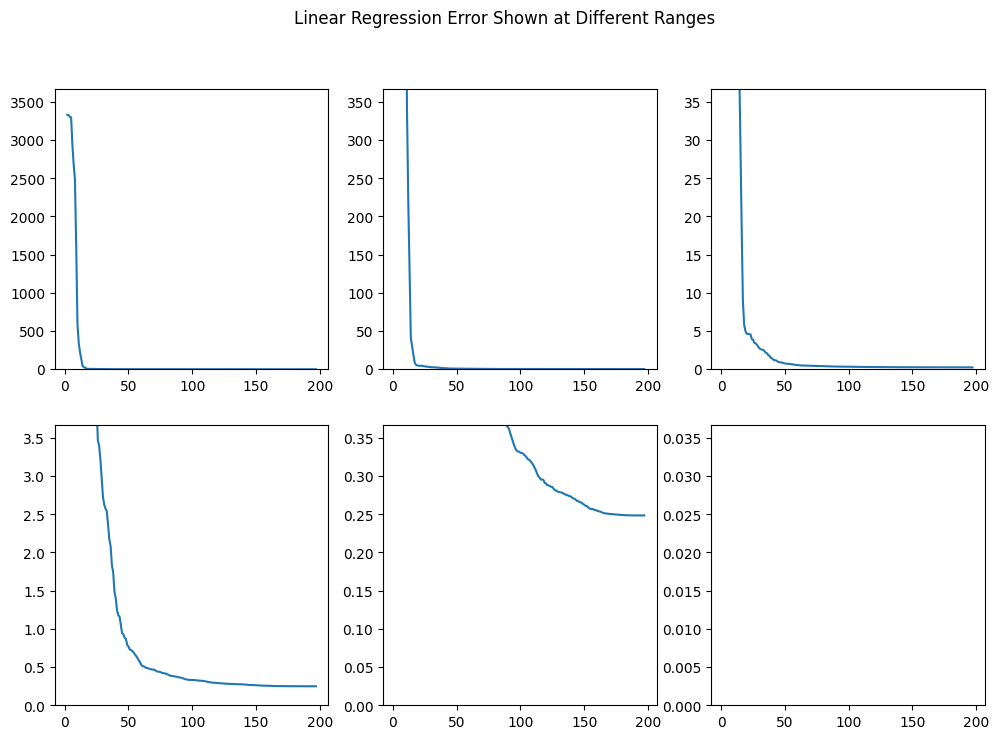

In [411]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, 1, -1), errors)
        ax[row, col].set_ylim(0, np.max(errors) * 1.1 / (10 ** count))
        count += 1

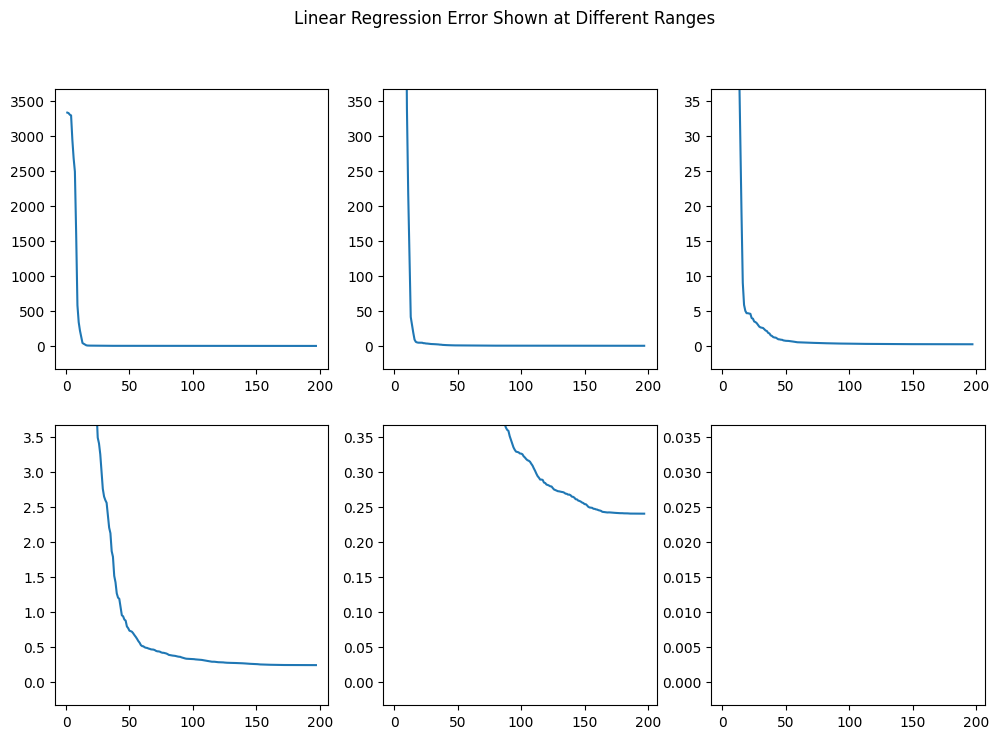

In [431]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, 0, -1), outSampleMSE)
        ax[row, col].set_ylim(-np.max(outSampleMSE) * .1 / (10 ** count), np.max(outSampleMSE) * 1.1 / (10 ** count))
        count += 1

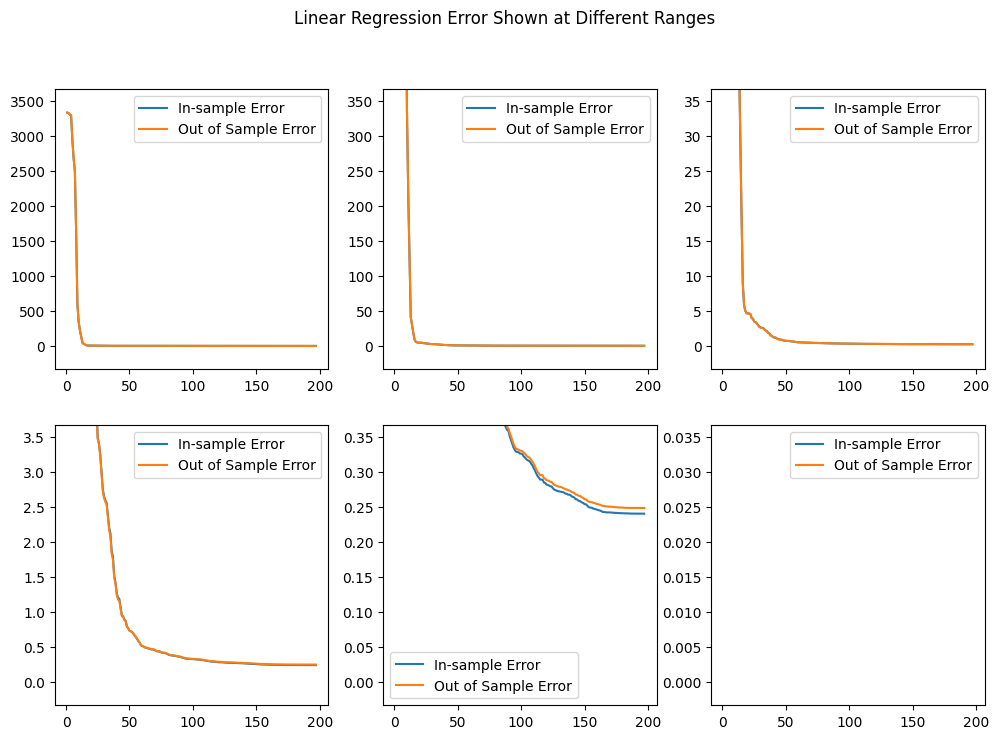

In [483]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        l1 = ax[row, col].plot(np.arange(197, 0, -1), outSampleMSE, label="In-sample Error")
        l2 = ax[row, col].plot(np.arange(197, 0, -1), errors, label="Out of Sample Error")

        ax[row, col].set_ylim(-np.max(outSampleMSE) * .1 / (10 ** count), np.max(outSampleMSE) * 1.1 / (10 ** count))
        count += 1

        ax[row, col].legend()

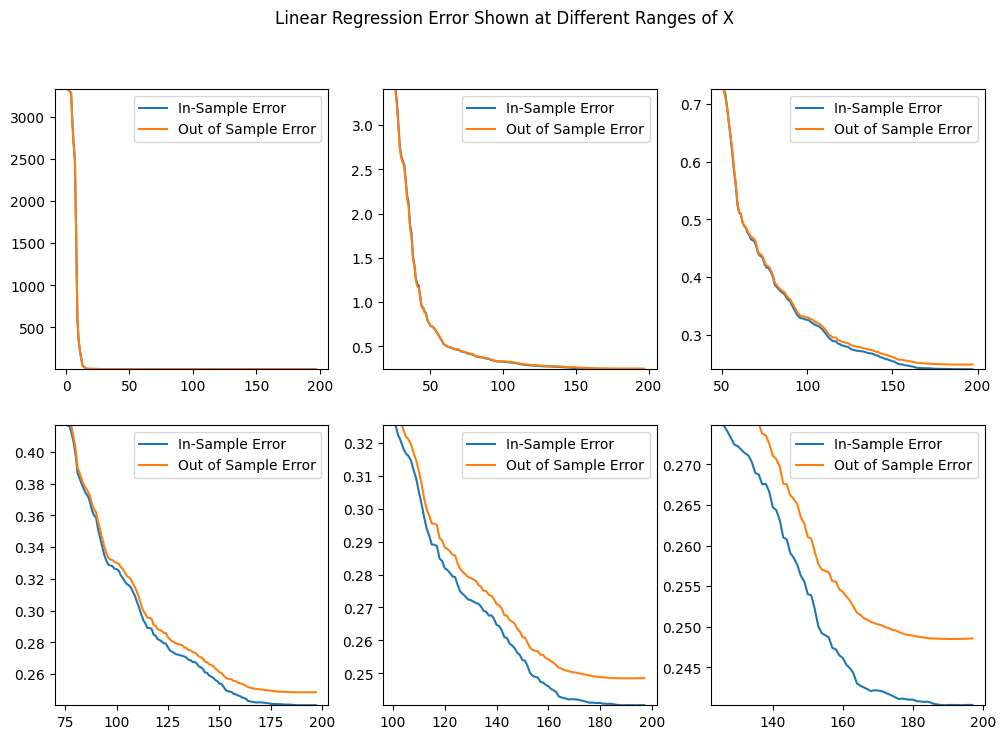

In [486]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges of X")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, count * 25, -1), outSampleMSE[:MAX_LASERS - count * 25], label="In-Sample Error")
        ax[row, col].plot(np.arange(197, count * 25, -1), errors[:MAX_LASERS - count * 25], label="Out of Sample Error")
        ax[row, col].legend()
        ax[row, col].set_ylim(np.min(outSampleMSE[:MAX_LASERS - count * 25]), np.max(outSampleMSE[:MAX_LASERS - count * 25]))
        count += 1